# Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
import gymnasium as gym
from gymnasium import spaces
import datetime
import my_library as mylib
# import importlib
# importlib.reload(my_library)
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pickle
pd.options.mode.chained_assignment = None

# Data manipulation

In [3]:
data = pd.read_csv('AAPL (2).csv', sep=',')
data['Date'] = pd.to_datetime(data['Date'],format='%Y-%m-%d')
adj_close = data['AAPL']
df = pd.DataFrame({'Date': data['Date'], 'log_ret': np.log(adj_close/adj_close.shift(1)).dropna(), 'AAPL_VOL': data['AAPL_VOL']}).dropna().set_index('Date')
sp500 = pd.read_csv('sp500_joined_closes (3).csv', sep=',').dropna(axis=1)
sp500.drop('AAPL ', axis=1, inplace=True)
sp500.drop('AAPL _VOL', axis=1, inplace=True)
data.set_index('Date', inplace=True)
new_cols = list([])
for i, col in enumerate(sp500.columns):
    if col.endswith(' '):
        new_cols.append(col[:-1])
    elif col.endswith(' _VOL'):
        new_cols.append(col[:-5]+'_VOL')
    else:
        new_cols.append(col)
sp500.columns = new_cols
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500 = sp500.set_index('Date')
col_stocks = [col for col in new_cols if not col.endswith('VOL')]
col_vols = [col for col in new_cols if col.endswith('VOL')]
any(col == 'Date' for col in col_stocks)
col_stocks = col_stocks[1:]
any(col == 'Date' for col in col_stocks)

False

In [4]:
sp500_lr = np.log(sp500[col_stocks]/sp500[col_stocks].shift(1))
sp500_lr = sp500_lr.drop(sp500_lr.index[0])
sp500_lr = sp500_lr.drop([col for col in sp500_lr.columns if sp500_lr[col].count() < 3633], axis=1)
df = df.join(sp500[col_vols],how='inner').dropna()
df = df.join(sp500_lr,how='inner').dropna()
df.describe()

log_ret      AAPL_VOL       MMM_VOL       AOS_VOL       ABT_VOL  \
count  3638.000000  3.638000e+03  3.638000e+03  3.638000e+03  3.638000e+03   
mean      0.000962  2.364617e+08  3.672072e+06  1.363582e+06  8.361895e+06   
std       0.017704  2.192065e+08  2.911937e+06  1.103023e+06  5.976096e+06   
min      -0.137708  2.404830e+07  7.785960e+05  2.042000e+05  1.067700e+06   
25%      -0.007537  8.900225e+07  2.380937e+06  8.305000e+05  4.614210e+06   
50%       0.000903  1.461266e+08  3.098058e+06  1.113950e+06  6.282250e+06   
75%       0.010319  3.192147e+08  4.108499e+06  1.586875e+06  1.024750e+07   
max       0.113157  1.880998e+09  6.043675e+07  3.248830e+07  7.810838e+07   

            ACN_VOL      ADBE_VOL       AMD_VOL       AES_VOL       AFL_VOL  \
count  3.638000e+03  3.638000e+03  3.638000e+03  3.638000e+03  3.638000e+03   
mean   2.772958e+06  3.756350e+06  4.659924e+07  5.907124e+06  4.438843e+06   
std    2.315021e+06  3.470823e+06  3.549588e+07  2.840392e+06  2.835895e+06   
min    5.281000e+05  5.892000e+05  0.000000e+00  9.862000e+05  8.789000e+05   
25%    1.813925e+06  2.136200e+06  1.889980e+07  4.110050e+06  2.677625e+06   
50%    2.333400e+06  2.906300e+06  3.877410e+07  5.336600e+06  3.640550e+06   
75%    3.150400e+06  4.277000e+06  6.321760e+07  7.026075e+06  5.307400e+06   
max    8.965590e+07  1.087524e+08  3.250584e+08  4.606760e+07  3.669320e+07   

       ...          WST          WDC           WY          WMB          WTW  \
count  ...  3638.000000  3638.000000  3638.000000  3638.000000  3638.000000   
mean   ...     0.000799     0.000218     0.000296     0.000441     0.000433   
std    ...     0.017123     0.027057     0.019391     0.024196     0.014200   
min    ...    -0.151802    -0.228719    -0.257132    -0.427912    -0.113525   
25%    ...    -0.007562    -0.013190    -0.009073    -0.009434    -0.005715   
50%    ...     0.000930     0.000462     0.000681     0.000740     0.000695   
75%    ...     0.009358     0.014244     0.009957     0.010422     0.007123   
max    ...     0.135745     0.190144     0.225664     0.295550     0.140681   

              WYNN          XEL          YUM         ZBRA          ZBH  
count  3638.000000  3638.000000  3638.000000  3638.000000  3638.000000  
mean      0.000211     0.000391     0.000539     0.000641     0.000194  
std       0.028792     0.012314     0.015034     0.022864     0.016214  
min      -0.280172    -0.135726    -0.208654    -0.272411    -0.150757  
25%      -0.013317    -0.005615    -0.006247    -0.009777    -0.007351  
50%      -0.000104     0.000632     0.000839     0.000930     0.000163  
75%       0.013625     0.007141     0.007597     0.011237     0.008326  
max       0.244422     0.106679     0.209032     0.158833     0.144790  

[8 rows x 860 columns]

Performing PCA on AAPL and SP500 stocks

In [5]:
cum_var_exp, PCs, regr_PCs, eig_vecs = mylib.PCA(df['log_ret'], sp500_lr, plot=False)

In [6]:
regr_PCs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   AAPL   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     310.6
Date:                Fri, 16 Aug 2024   Prob (F-statistic):               0.00
Time:                        21:30:19   Log-Likelihood:                 10639.
No. Observations:                3638   AIC:                        -2.126e+04
Df Residuals:                    3627   BIC:                        -2.119e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.384      0.166      -0.000       0.001
PC0            0.0416      0.001     36.015      0.000       0.039       0.044
PC1            0.0038      0.003      1.182      0.237      -0.003       0.010
PC2           -0.0669      0.003    -22.483      0.000      -0.073      -0.061
PC3            0.0037      0.005      0.809      0.419      -0.005       0.012
PC4            0.0286      0.004      6.665      0.000       0.020       0.037
PC5            0.0045      0.005      0.840      0.401      -0.006       0.015
PC6            0.0124      0.006      2.142      0.032       0.001       0.024
PC7           -0.0606      0.006    -10.537      0.000      -0.072      -0.049
PC8            0.0152      0.006      2.348      0.019       0.003       0.028
PC9            0.0277      0.007      4.146      0.000       0.015       0.041
==============================================================================
Omnibus:                      577.011   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10422.390
Skew:                          -0.033   Prob(JB):                         0.00
Kurtosis:                      11.292   Cond. No.                         33.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
Y = PCs['AAPL']

In [8]:
[i-1 for i,p in enumerate(regr_PCs.tvalues) if abs(p) > 1.96]

[0, 2, 4, 6, 7, 8, 9]

In [9]:
t_vals = regr_PCs.tvalues.drop('const')

In [10]:
t_vals.drop([p for p in t_vals.index if abs(t_vals[p]) == abs(t_vals).min()], inplace=True)
list(t_vals.index)

['PC0', 'PC1', 'PC2', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9']

In [11]:
X = PCs[list(t_vals.index)]
X

PC0       PC1       PC2       PC4       PC5       PC6  \
Date                                                                     
2010-01-05  0.077616  0.106817  0.077500 -0.054376 -0.000260  0.025579   
2010-01-06  0.046104  0.026022  0.032150  0.053552 -0.018836  0.024003   
2010-01-07  0.119045  0.058188  0.074514 -0.133750  0.015196  0.014245   
2010-01-08  0.056234  0.054203 -0.034621  0.064576 -0.060854 -0.019069   
2010-01-11  0.059334 -0.041982  0.015663  0.001116  0.002717 -0.004994   
...              ...       ...       ...       ...       ...       ...   
2024-06-12  0.112613  0.110088 -0.074268 -0.032677 -0.050849 -0.080531   
2024-06-13 -0.053387 -0.051662 -0.025688 -0.036519 -0.002940  0.011562   
2024-06-14 -0.126917 -0.086623 -0.062926 -0.009177  0.060976 -0.016470   
2024-06-17  0.146218  0.081919 -0.007522 -0.055556 -0.052291  0.045627   
2024-06-18  0.058779  0.021141  0.014830  0.011469 -0.008826 -0.053113   

                 PC7       PC8       PC9  
Date                                      
2010-01-05 -0.019749  0.070622 -0.003594  
2010-01-06  0.056333 -0.046954  0.009634  
2010-01-07  0.049853 -0.027073 -0.019580  
2010-01-08 -0.005648 -0.041529 -0.015592  
2010-01-11  0.009890 -0.006846 -0.061461  
...              ...       ...       ...  
2024-06-12  0.019911 -0.005482 -0.013693  
2024-06-13 -0.003649  0.000200  0.013916  
2024-06-14 -0.006781  0.005812  0.071929  
2024-06-17 -0.068626 -0.028992  0.052491  
2024-06-18 -0.022793  0.027428  0.013870  

[3638 rows x 9 columns]

In [12]:
regr_PCs = sm.OLS(Y, X).fit()
regr_PCs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   AAPL   R-squared (uncentered):                   0.463
Model:                            OLS   Adj. R-squared (uncentered):              0.461
Method:                 Least Squares   F-statistic:                              347.0
Date:                Fri, 16 Aug 2024   Prob (F-statistic):                        0.00
Time:                        21:30:19   Log-Likelihood:                          10638.
No. Observations:                3638   AIC:                                 -2.126e+04
Df Residuals:                    3629   BIC:                                 -2.120e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PC0            0.0420      0.001     37.553      0.000       0.040       0.044
PC1            0.0037      0.003      1.156      0.248      -0.003       0.010
PC2           -0.0673      0.003    -22.760      0.000      -0.073      -0.061
PC4            0.0281      0.004      6.593      0.000       0.020       0.036
PC5            0.0045      0.005      0.836      0.403      -0.006       0.015
PC6            0.0135      0.006      2.371      0.018       0.002       0.025
PC7           -0.0614      0.006    -10.796      0.000      -0.073      -0.050
PC8            0.0150      0.006      2.330      0.020       0.002       0.028
PC9            0.0280      0.007      4.193      0.000       0.015       0.041
==============================================================================
Omnibus:                      577.562   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10457.001
Skew:                          -0.033   Prob(JB):                         0.00
Kurtosis:                      11.305   Cond. No.                         8.03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
t_vals = regr_PCs.tvalues
t_vals.drop([p for p in t_vals.index if abs(t_vals[p]) == abs(t_vals).min()], inplace=True)
list(t_vals.index)
X = PCs[list(t_vals.index)]
X = sm.add_constant(X)
regr_PCs = sm.OLS(Y, X).fit()
regr_PCs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   AAPL   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     388.2
Date:                Fri, 16 Aug 2024   Prob (F-statistic):               0.00
Time:                        21:30:19   Log-Likelihood:                 10639.
No. Observations:                3638   AIC:                        -2.126e+04
Df Residuals:                    3629   BIC:                        -2.120e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.383      0.167      -0.000       0.001
PC0            0.0419      0.001     37.415      0.000       0.040       0.044
PC1            0.0036      0.003      1.123      0.261      -0.003       0.010
PC2           -0.0670      0.003    -22.657      0.000      -0.073      -0.061
PC4            0.0285      0.004      6.704      0.000       0.020       0.037
PC6            0.0136      0.006      2.395      0.017       0.002       0.025
PC7           -0.0613      0.006    -10.794      0.000      -0.072      -0.050
PC8            0.0157      0.006      2.439      0.015       0.003       0.028
PC9            0.0280      0.007      4.193      0.000       0.015       0.041
==============================================================================
Omnibus:                      577.002   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10419.159
Skew:                          -0.035   Prob(JB):                         0.00
Kurtosis:                      11.290   Cond. No.                         32.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
t_vals = regr_PCs.tvalues
any(abs(t_vals) < 1.96)

True

In [15]:
t_vals = regr_PCs.tvalues
t_vals = regr_PCs.tvalues.drop('const')
t_vals.drop([p for p in t_vals.index if abs(t_vals[p]) == abs(t_vals).min()], inplace=True)
list(t_vals.index)
X = PCs[list(t_vals.index)]
regr_PCs = sm.OLS(Y, X).fit()
regr_PCs.summary()
t_vals = regr_PCs.tvalues
any(abs(t_vals) < 1.96)

False

In [16]:
regr_PCs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   AAPL   R-squared (uncentered):                   0.462
Model:                            OLS   Adj. R-squared (uncentered):              0.461
Method:                 Least Squares   F-statistic:                              445.9
Date:                Fri, 16 Aug 2024   Prob (F-statistic):                        0.00
Time:                        21:30:20   Log-Likelihood:                          10637.
No. Observations:                3638   AIC:                                 -2.126e+04
Df Residuals:                    3631   BIC:                                 -2.122e+04
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
PC0            0.0425      0.001     41.636      0.000       0.040       0.044
PC2           -0.0669      0.003    -22.738      0.000      -0.073      -0.061
PC4            0.0292      0.004      7.014      0.000       0.021       0.037
PC6            0.0140      0.006      2.466      0.014       0.003       0.025
PC7           -0.0627      0.006    -11.249      0.000      -0.074      -0.052
PC8            0.0158      0.006      2.466      0.014       0.003       0.028
PC9            0.0278      0.007      4.181      0.000       0.015       0.041
==============================================================================
Omnibus:                      576.686   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10400.402
Skew:                          -0.035   Prob(JB):                         0.00
Kurtosis:                      11.283   Cond. No.                         7.87
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Add the relevant PCs to the df

In [17]:
PCs['AAPL']

Date
2010-01-05    0.001727
2010-01-06   -0.016034
2010-01-07   -0.001850
2010-01-08    0.006626
2010-01-11   -0.008861
                ...   
2024-06-12    0.028178
2024-06-13    0.005476
2024-06-14   -0.008202
2024-06-17    0.019480
2024-06-18   -0.011045
Name: AAPL, Length: 3638, dtype: float64

In [18]:
dataframe = pd.DataFrame(PCs[list(t_vals.index)])
dataframe['log_ret'] = df['log_ret']
dataframe

PC0       PC2       PC4       PC6       PC7       PC8  \
Date                                                                     
2010-01-05  0.077616  0.077500 -0.054376  0.025579 -0.019749  0.070622   
2010-01-06  0.046104  0.032150  0.053552  0.024003  0.056333 -0.046954   
2010-01-07  0.119045  0.074514 -0.133750  0.014245  0.049853 -0.027073   
2010-01-08  0.056234 -0.034621  0.064576 -0.019069 -0.005648 -0.041529   
2010-01-11  0.059334  0.015663  0.001116 -0.004994  0.009890 -0.006846   
...              ...       ...       ...       ...       ...       ...   
2024-06-12  0.112613 -0.074268 -0.032677 -0.080531  0.019911 -0.005482   
2024-06-13 -0.053387 -0.025688 -0.036519  0.011562 -0.003649  0.000200   
2024-06-14 -0.126917 -0.062926 -0.009177 -0.016470 -0.006781  0.005812   
2024-06-17  0.146218 -0.007522 -0.055556  0.045627 -0.068626 -0.028992   
2024-06-18  0.058779  0.014830  0.011469 -0.053113 -0.022793  0.027428   

                 PC9   log_ret  
Date                            
2010-01-05 -0.003594  0.001727  
2010-01-06  0.009634 -0.016034  
2010-01-07 -0.019580 -0.001850  
2010-01-08 -0.015592  0.006626  
2010-01-11 -0.061461 -0.008861  
...              ...       ...  
2024-06-12 -0.013693  0.028178  
2024-06-13  0.013916  0.005476  
2024-06-14  0.071929 -0.008202  
2024-06-17  0.052491  0.019480  
2024-06-18  0.013870 -0.011045  

[3638 rows x 8 columns]

# Create the environment and agent, training, and backtesting

## Define the environment and agent

In [33]:
class TradingEnv(gym.Env):
    def __init__(self, df, rf):
        super(TradingEnv, self).__init__()

        self.current_step = 0
        self.data = df.iloc[:,df.columns != 'log_ret']
        self.y = df['log_ret']
        self.initial_position = pd.DataFrame({'0': [0], '1': [1]}) # Initial position is 1000 in risk_free asset
        self.position = self.initial_position.copy()
        self.initial_portfolio_value = list([1000])
        self.money = pd.DataFrame(self.initial_portfolio_value[0] * self.position)
        self.rf = rf
        self.pos_sup = 2
        self.pos_inf = -1
        # Define action and observation space
        
        # Only one stock, the rest is in cash
        self.action_space = np.arange(self.pos_inf, self.pos_sup, 0.15).round(2)
        # If two stocks, then self.action_space = spaces.Box(low=np.array([0,0]), high=np.array([1,1]), dtype=np.float32)
        
        # observation_space is a dataframe with historical data
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(1,df.shape[1]+5), dtype=np.float32)
           
    def step(self, state, action):
        # Execute one time step within the environment
        self.current_step += 1
        self.flag = 0

        # End the episode if we've run out of data
        if self.current_step >= days_train:
            return self.position, 0, True

        # Take the action (<0: short stock, ==0: hold positions, >0: buy stock)
        # action = action[0][0]
        if (action > self.pos_sup) or (action < self.pos_inf):
            reward = - 1000
            self.flag = 1
            new_row_pos = pd.DataFrame([[self.position.iloc[self.current_step-1,0], self.position.iloc[self.current_step-1,1]]])
            self.position = pd.concat([self.position, new_row_pos], axis=0, ignore_index=True)    
            pv = np.exp(state[0]) * self.money.iloc[self.current_step-1,0] + self.money.iloc[self.current_step-1,1] * (1+self.rf)
            new_row_money = pd.DataFrame([[self.position.iloc[self.current_step,0]*self.portfolio_value[self.current_step], self.position.iloc[self.current_step,1]*self.portfolio_value[self.current_step]]])
            self.money = pd.concat([self.money, new_row_money], axis=0, ignore_index=True)
            observation = np.concatenate(([self.y_train.iloc[self.current_step]], self.df_train.iloc[self.current_step], [self.position.iloc[self.current_step,0], self.position.iloc[self.current_step,1], self.money.iloc[self.current_step,0], self.money.iloc[self.current_step,1], self.portfolio_value[self.current_step]]))
            return new_row_pos, reward, True
        new_port_value = np.exp(state[0]) * self.money.iloc[self.current_step-1,0] + self.money.iloc[self.current_step-1,1] * (1+self.rf)
        self.portfolio_value.append(new_port_value)
        
        if abs(action - self.position.iloc[self.current_step-1,0]) >= tol:
            new_row_pos = pd.DataFrame([[action, (1 - action)]])
        else:
            new_row_pos = pd.DataFrame([[self.position.iloc[self.current_step-1,0], self.position.iloc[self.current_step-1,1]]])
        self.position = pd.concat([self.position, new_row_pos], axis=0, ignore_index=True)    
        new_row_money = pd.DataFrame([[self.position.iloc[self.current_step,0]*self.portfolio_value[self.current_step], self.position.iloc[self.current_step,1]*self.portfolio_value[self.current_step]]])
        self.money = pd.concat([self.money, new_row_money], axis=0, ignore_index=True)

        if self.flag == 0:
            reward = (self.portfolio_value[self.current_step] - self.portfolio_value[self.current_step-1])/self.portfolio_value[self.current_step-1]
        
        done = self.current_step >= days_train - 1
        
        observation = np.concatenate(([self.y_train.iloc[self.current_step]], self.df_train.iloc[self.current_step], [self.position.iloc[self.current_step,0], self.position.iloc[self.current_step,1], self.money.iloc[self.current_step,0], self.money.iloc[self.current_step,1], self.portfolio_value[self.current_step]]))

        return observation, reward, done

    def reset(self, noise=True):
        # Reset the state of the environment to an initial state
        self.current_step = 0
        a = (3 * np.random.rand(1) - 1)[0].round(5)
        self.position = pd.DataFrame([a,1-a]).T
        self.portfolio_value = self.initial_portfolio_value.copy()
        self.money = pd.DataFrame(self.portfolio_value[0] * self.position)
        starting_point = np.random.randint(0, self.data.shape[0]-days_train)
        self.df_train = self.data.iloc[starting_point:starting_point+days_train,].copy()
        self.y_train = self.y.iloc[starting_point:starting_point+days_train,].copy()
        if noise:
            for i in range(days_train):
                b = np.log((0.05 * np.random.rand(1) + 0.975)[0]).round(5)
                self.y_train.iloc[i] += b
                for j in range(len(self.df_train.columns)):
                    c = np.log((0.05 * np.random.rand(1) + 0.975)[0]).round(5)
                    self.df_train.iloc[i,j] += c

        # The first observation is the returns of the first day, the initial position, and the initial portfolio value
        observation = np.insert(self.df_train.iloc[self.current_step].values.flatten(),0,self.y_train.iloc[self.current_step])
        observation = np.concatenate((observation, [self.position.iloc[self.current_step,0], self.position.iloc[self.current_step,1], self.money.iloc[self.current_step,0], self.money.iloc[self.current_step,1], self.portfolio_value[self.current_step]]))

        return observation

    def render(self, mode='human'):
        # Render the environment to the screen
        if mode == 'human':
            print(f"Current Step: {self.current_step}")
            print(f"Current Position:\n Stock: {self.position.iloc[self.current_step,0]}\n R_f: {self.position.iloc[self.current_step,1]}")
            print(f"env.money:\n Stock: {self.money.iloc[self.current_step,0]}\n R_f: {self.money.iloc[self.current_step,1]}")
            print(f"Portfolio Value: {self.portfolio_value[self.current_step]}")
    
    def train(self, agent, episodes, days):
        self.days_train = days
        for e in range(episodes):
            print(f"Episode: {e+1}/{episodes}")
            state = env.reset()
            # state = np.reshape(state, [1, state_size])
            for time in range(days):
                print(f"Port. Value: {env.portfolio_value[env.current_step]}") 
                action = agent.act(state)*0.15-1
                print(f"condition: {state[0]}")
                print(f"Action: {action}")
                next_state, reward, done = env.step(state,action)
                if agent.flag == 1:
                    agent.reward_pred *= (1+reward)
                    agent.flag = 0
                # next_state = np.reshape(next_state, [1, state_size])
                agent.remember(state, action, reward, next_state, done)
                self.render()
                print(f"Reward: {reward}\n")
                state = next_state
                if done:
                    print(f"Episode: {e+1}/{episodes}, Score: {time}, Epsilon: {agent.epsilon:.2}\n\n\n")
                    break
            if len(agent.memory) > 32:
                agent.replay(32)
    
    def backtest(self, agent, days_test):
        state = self.reset(noise=False)
        total_reward = 1
        for time in range(days_test):
            action = agent.act(state, train=False) * 0.15 - 1
            next_state, reward, done = self.step(state,action)
            total_reward *= (1 + reward)
            state = next_state
            if done:
                break
        annualized_return = (total_reward ** (252 / days_test) - 1) * 100
        print(f"Days: {time}")
        return annualized_return
        





class DQN:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=3000)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()
        self.reward_pred = 1
        self.n_exploit = 0
        self.flag = 0

    def _build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='sigmoid'))
        model.add(Dense(64, activation='sigmoid'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, train=True):
        if train and np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        print("EXPLOITATION")
        self.flag = 1
        self.n_exploit += 1
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma * np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][int(action)] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

## Short Training

In [19]:
rf = (1+0.02)**(1/252) - 1
tol = 0.01
episodes = 5
days_train = 252

env = TradingEnv(dataframe, rf)
state_size = env.observation_space.shape[0]
action_size = len(env.action_space)
agent = DQN(state_size, action_size)

env.train(agent, episodes, days_train)
print(f"Annualized rewards predicted: {(agent.reward_pred**(252/agent.n_exploit)-1)*100:.2f}%")


C:\Users\pietr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode: 1/5
Port. Value: 1000
condition: 0.02331886825241859
Action: -0.85
Current Step: 1
Current Position:
 Stock: -0.85
 R_f: 1.85
env.money:
 Stock: -872.1537969238742
 R_f: 1898.2170874225499
Portfolio Value: 1026.0632904986755
Reward: 0.02606329049867554

Port. Value: 1026.0632904986755
condition: 0.012350970383618052
Action: 1.4
Current Step: 2
Current Position:
 Stock: 1.4
 R_f: -0.3999999999999999
env.money:
 Stock: 1421.523207094519
 R_f: -406.14948774129107
Portfolio Value: 1015.3737193532279
Reward: -0.010418042672837873

Port. Value: 1015.3737193532279
condition: 0.006505660494271315
Action: -0.55
Current Step: 3
Current Position:
 Stock: -0.55
 R_f: 1.55
env.money:
 Stock: -563.5409432581388
 R_f: 1588.1608400911184
Portfolio Value: 1024.6198968329795
Reward: 0.009106181599461966

Port. Value: 1024.6198968329795
condition: 0.0033942502196278564
Action: 1.5499999999999998
Current Step: 4
Current Position:
 Stock: 1.5499999999999998
 R_f: -0.5499999999999998
env.money:
 St

In [20]:
annualized_return = env.backtest(agent, days_test=252)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20m

In [21]:
print(f"Annualized Return on backtesting: {annualized_return:.2f}%")

Annualized Return on backtesting: 19.72%


## Longer Training

In [22]:
rf = (1+0.02)**(1/252) - 1
tol = 0.01
episodes = 20
days_train = 252

env = TradingEnv(dataframe, rf)
state_size = env.observation_space.shape[0]
action_size = len(env.action_space)
agent = DQN(state_size, action_size)

env.train(agent, episodes, days_train)
print(f"Annualized rewards predicted: {(agent.reward_pred**(252/agent.n_exploit)-1)*100:.2f}%")

C:\Users\pietr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode: 1/20
Port. Value: 1000
condition: 0.02596620645571443
Action: -0.85
Current Step: 1
Current Position:
 Stock: -0.85
 R_f: 1.85
env.money:
 Stock: -884.1520415105138
 R_f: 1924.3309138758243
Portfolio Value: 1040.1788723653103
Reward: 0.04017887236531033

Port. Value: 1040.1788723653103
condition: 0.0041742568448613175
Action: 1.4
Current Step: 2
Current Position:
 Stock: 1.4
 R_f: -0.3999999999999999
env.money:
 Stock: 1451.284386215767
 R_f: -414.65268177593333
Portfolio Value: 1036.6317044398336
Reward: -0.0034101518687941383

Port. Value: 1036.6317044398336
condition: -0.011546396818515551
Action: -1.0
Current Step: 3
Current Position:
 Stock: -1.0
 R_f: 2.0
env.money:
 Stock: -1019.938384388934
 R_f: 2039.876768777868
Portfolio Value: 1019.938384388934
Reward: -0.01610342417601458

Port. Value: 1019.938384388934
condition: 0.009013436545831895
Action: 0.34999999999999987
Current Step: 4
Current Position:
 Stock: 0.34999999999999987
 R_f: 0.6500000000000001
env.money:
 Stoc

In [25]:
random.seed(123456789)
annualized_return = env.backtest(agent, days_test=252)
print(f"Annualized Return on backtesting: {annualized_return:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47m

In [28]:
# Serialize the classifier to a file named 'my_classifier.pkl'
with open('agent.pkl', 'wb') as file:
    pickle.dump(agent, file)

# To later deserialize the classifier from the file
# with open('agent.pkl', 'rb') as file:
#     loaded_agent = pickle.load(file)

## Test with new data

In [20]:
# Data manipulation
data_NEW = pd.read_csv('AAPL_NEW.csv', sep=',')
data_NEW['Date'] = pd.to_datetime(data_NEW['Date'],format='%Y-%m-%d')
adj_close_NEW = data_NEW['AAPL']
df1 = pd.DataFrame({'Date': data_NEW['Date'], 'log_ret': np.log(adj_close_NEW/adj_close_NEW.shift(1)).dropna(), 'AAPL_VOL': data_NEW['AAPL_VOL']}).dropna().set_index('Date')
sp500_NEW = pd.read_csv('sp500_joined_closes_NEW.csv', sep=',').dropna(axis=1)
sp500_NEW.drop('AAPL ', axis=1, inplace=True)
sp500_NEW.drop('AAPL _VOL', axis=1, inplace=True)
data_NEW.set_index('Date', inplace=True)
new_cols = list([])
for i, col in enumerate(sp500_NEW.columns):
    if col.endswith(' '):
        new_cols.append(col[:-1])
    elif col.endswith(' _VOL'):
        new_cols.append(col[:-5]+'_VOL')
    else:
        new_cols.append(col)
sp500_NEW.columns = new_cols
sp500_NEW['Date'] = pd.to_datetime(sp500_NEW['Date'])
sp500_NEW = sp500_NEW.set_index('Date')
sp500_NEW = sp500_NEW[[col for col in sp500.columns]]
new_cols = sp500_NEW.columns
col_stocks = [col for col in new_cols if not col.endswith('VOL')]
col_vols = [col for col in new_cols if col.endswith('VOL')]
any(col == 'Date' for col in col_stocks)

False

In [22]:
sp500_lr_NEW = np.log(sp500_NEW[col_stocks]/sp500_NEW[col_stocks].shift(1))
sp500_lr_NEW = sp500_lr_NEW.drop(sp500_lr_NEW.index[0])
# sp500_lr_NEW = sp500_lr_NEW.drop([col for col in sp500_lr_NEW.columns if sp500_lr_NEW[col].count() < 3633], axis=1)
df1 = df1.join(sp500_NEW[col_vols],how='inner').dropna()
df1 = df1.join(sp500_lr_NEW,how='inner').dropna()
df1.describe()

log_ret      AAPL_VOL       MMM_VOL       AOS_VOL       ABT_VOL  \
count  37.000000  3.700000e+01  3.700000e+01  3.700000e+01  3.700000e+01   
mean    0.001485  6.291276e+07  4.808686e+06  1.102470e+06  7.180724e+06   
std     0.016457  3.559902e+07  5.087143e+06  4.212829e+05  3.317233e+06   
min    -0.049366  3.631180e+07  1.230800e+06  5.398000e+05  2.017800e+06   
25%    -0.004816  4.716110e+07  2.884900e+06  8.747000e+05  4.970800e+06   
50%     0.003978  5.734590e+07  3.381000e+06  1.025900e+06  6.356600e+06   
75%     0.013642  6.351640e+07  4.598100e+06  1.190100e+06  8.611600e+06   
max     0.028689  2.464214e+08  3.274890e+07  2.721300e+06  1.945270e+07   

            ACN_VOL      ADBE_VOL       AMD_VOL       AES_VOL       AFL_VOL  \
count  3.700000e+01  3.700000e+01  3.700000e+01  3.700000e+01  3.700000e+01   
mean   3.404114e+06  2.619322e+06  5.564599e+07  8.377762e+06  2.296111e+06   
std    2.325463e+06  1.055446e+06  1.849204e+07  4.929767e+06  1.388765e+06   
min    1.629200e+06  1.272600e+06  2.698090e+07  3.243100e+06  1.040000e+06   
25%    2.283500e+06  2.075400e+06  4.220270e+07  5.224700e+06  1.515000e+06   
50%    2.682700e+06  2.368400e+06  5.043670e+07  7.055500e+06  1.898600e+06   
75%    3.640500e+06  3.054500e+06  6.185710e+07  9.712200e+06  2.212000e+06   
max    1.490550e+07  6.614100e+06  1.143068e+08  2.844530e+07  7.552800e+06   

       ...        WST        WDC         WY        WMB        WTW       WYNN  \
count  ...  37.000000  37.000000  37.000000  37.000000  37.000000  37.000000   
mean   ...  -0.002862  -0.005789   0.001550   0.000455   0.001581  -0.005127   
std    ...   0.031343   0.033936   0.017124   0.014376   0.012160   0.017542   
min    ...  -0.155438  -0.102300  -0.029672  -0.036737  -0.031149  -0.050899   
25%    ...  -0.008031  -0.019890  -0.011173  -0.007505  -0.004725  -0.015403   
50%    ...   0.000247  -0.003337   0.000000   0.000466   0.002202  -0.005169   
75%    ...   0.011730   0.015123   0.013181   0.007239   0.008741   0.004030   
max    ...   0.038771   0.059451   0.048825   0.037830   0.038933   0.036576   

             XEL        YUM       ZBRA        ZBH  
count  37.000000  37.000000  37.000000  37.000000  
mean    0.002930   0.000684   0.003053   0.000827  
std     0.012876   0.011661   0.019387   0.014313  
min    -0.029899  -0.026390  -0.061022  -0.034919  
25%    -0.003605  -0.007918  -0.006052  -0.005720  
50%     0.002284   0.001043   0.004828   0.001383  
75%     0.010769   0.008022   0.013832   0.005858  
max     0.027938   0.026133   0.038148   0.032862  

[8 rows x 860 columns]

In [23]:
eig_vecs.shape

(429, 429)

In [24]:
sp500_lr_NEW.shape

(37, 429)

In [25]:
# Applying PCA trasformation on new data
PCs = mylib.apply_PCA(df1['log_ret'], sp500_lr_NEW, eig_vecs)

# Add the relevant PCs to the df
dataframe1 = pd.DataFrame(PCs[['PC0','PC2','PC4','PC6','PC7','PC8','PC9']])
dataframe1['log_ret'] = df1['log_ret']
dataframe1

PC0       PC2       PC4       PC6       PC7       PC8  \
Date                                                                     
2024-06-21  0.032098 -0.044725 -0.026946  0.025829  0.017120  0.024109   
2024-06-24  0.108855  0.164992  0.035454  0.025630  0.054299  0.013245   
2024-06-25 -0.168156 -0.050005  0.059747 -0.025795 -0.101840  0.024897   
2024-06-26 -0.067611 -0.022626 -0.008002 -0.005133  0.009854  0.006941   
2024-06-27  0.007897 -0.003758  0.004374 -0.028408  0.002168 -0.048445   
2024-06-28  0.025145  0.058401 -0.019290 -0.039767  0.014498  0.056693   
2024-07-01 -0.166925  0.015846  0.015614 -0.066021 -0.056684  0.025330   
2024-07-02  0.084907 -0.013881 -0.004463 -0.036978 -0.045228 -0.006042   
2024-07-03  0.005339 -0.021784  0.067656 -0.024119 -0.008778 -0.012386   
2024-07-05 -0.029148 -0.117566 -0.013889  0.017159 -0.005398 -0.005674   
2024-07-08  0.043645  0.002638 -0.002341 -0.003961 -0.014899  0.028226   
2024-07-09 -0.032184  0.049827 -0.044527 -0.049399 -0.033534  0.053733   
2024-07-10  0.195841 -0.012132  0.022839 -0.024883  0.010347  0.024281   
2024-07-11  0.246333  0.067059 -0.027132  0.003854  0.221205 -0.055913   
2024-07-12  0.155994 -0.044528  0.011456  0.016301  0.003149 -0.013565   
2024-07-15  0.022256  0.063767 -0.011035 -0.060907  0.004251  0.014296   
2024-07-16  0.357199  0.001807 -0.059808  0.080377  0.090335 -0.005053   
2024-07-17 -0.061218  0.184284 -0.076544  0.043197  0.083875  0.016113   
2024-07-18 -0.181452  0.062625  0.036303 -0.016822 -0.030485 -0.034186   
2024-07-19 -0.145646 -0.003132 -0.030596  0.021049  0.046521  0.002287   
2024-07-22  0.171904 -0.106663  0.004849 -0.069981 -0.032078 -0.010473   
2024-07-23 -0.075129  0.016776 -0.065512 -0.049255  0.008829 -0.036209   
2024-07-24 -0.226713  0.069254 -0.006201 -0.025746  0.054053  0.019168   
2024-07-25  0.019826  0.095688 -0.036408 -0.012992  0.079899 -0.045418   
2024-07-26  0.290118  0.031354 -0.026742  0.027531  0.013777 -0.008185   
2024-07-29  0.030046 -0.052163 -0.009794  0.037232  0.010460 -0.022586   
2024-07-30  0.088907  0.080579 -0.074420  0.023191  0.083738 -0.046196   
2024-07-31  0.088067 -0.128039  0.148519 -0.030263 -0.117509  0.005666   
2024-08-01 -0.212310 -0.007083 -0.058343 -0.006303  0.174773 -0.040968   
2024-08-02 -0.375950 -0.034747 -0.106441  0.058728  0.123666 -0.108224   
2024-08-05 -0.502911  0.014776 -0.010045  0.012397  0.006942 -0.039000   
2024-08-06  0.196460 -0.004879 -0.017554 -0.011948  0.010192  0.027438   
2024-08-07 -0.167012  0.086340  0.015406 -0.024517 -0.046887 -0.048296   
2024-08-08  0.375709 -0.091666  0.089488  0.009697 -0.063539  0.045670   
2024-08-09  0.032493  0.014589 -0.016224 -0.019149 -0.016954  0.008690   
2024-08-12 -0.095302 -0.001105  0.079333 -0.019540 -0.015653 -0.028579   
2024-08-13  0.235017 -0.106761 -0.027511  0.007354 -0.058504  0.051591   

                 PC9   log_ret  
Date                            
2024-06-21 -0.000856 -0.010499  
2024-06-24  0.027070  0.003128  
2024-06-25  0.018127  0.004458  
2024-06-26 -0.028319  0.019796  
2024-06-27  0.058184  0.003978  
2024-06-28  0.015417 -0.016388  
2024-07-01  0.058815  0.028689  
2024-07-02  0.031049  0.016109  
2024-07-03 -0.011366  0.005794  
2024-07-05  0.017846  0.021390  
2024-07-08 -0.034018  0.006518  
2024-07-09 -0.022458  0.003768  
2024-07-10 -0.043860  0.018629  
2024-07-11 -0.025060 -0.023495  
2024-07-12 -0.001110  0.012966  
2024-07-15  0.101883  0.016605  
2024-07-16 -0.114550  0.001790  
2024-07-17  0.057725 -0.025621  
2024-07-18  0.038172 -0.020749  
2024-07-19 -0.033542  0.000580  
2024-07-22 -0.033893 -0.001561  
2024-07-23  0.012932  0.004677  
2024-07-24 -0.078317 -0.029176  
2024-07-25  0.028386 -0.004816  
2024-07-26 -0.026183  0.002159  
2024-07-29 -0.020752  0.001284  
2024-07-30 -0.013115  0.002563  
2024-07-31 -0.009054  0.014880  
2024-08-01  0.005197 -0.016893  
2024-08-02  0.076131  0.006846  
2024-08-05  0.031504 -0.049366  
2024-08-06  0.054746 -0.009796  
2024-08-

In [35]:
with open('agent.pkl', 'rb') as file:
    loaded_agent = pickle.load(file)

rf = (1+0.02)**(1/252) - 1
tol = 0.01
episodes = 20
days_train = 36

env1 = TradingEnv(dataframe1, rf)
agent1 = loaded_agent

In [41]:
random.seed(123456789)
annualized_return1 = env1.backtest(agent1, days_test=dataframe1.shape[0])
print(f"Annualized Return on NEW DATA: {annualized_return1:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27m

### Perform multiple tests

In [42]:
n_tests = 200
annualized_returns = list([])
avg_return = 0
for i in range(n_tests):
    annualized_returns.append(env1.backtest(agent1, days_test=dataframe1.shape[0]))
    avg_return += annualized_returns[i]
avg_return /= n_tests
std_return = np.std(annualized_returns)
print(f"Average Annualized Return on NEW DATA: {avg_return:.2f}%")
print(f"Standard Deviation of Annualized Returns on NEW DATA: {std_return:.2f}%")
print(f"Coefficient of Variation of Annualized Returns on NEW DATA: {std_return/avg_return:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
EXPLOITATION
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27m

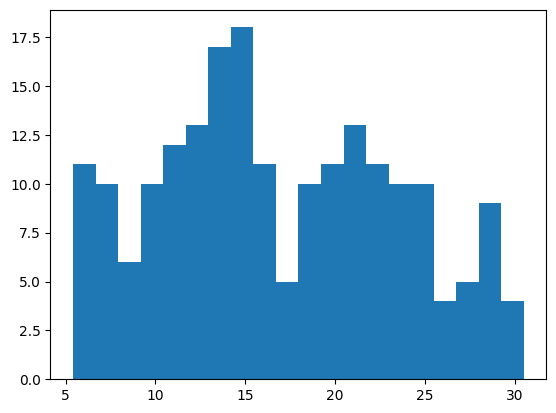

In [53]:
plt.hist(annualized_returns, bins=20)
plt.show()

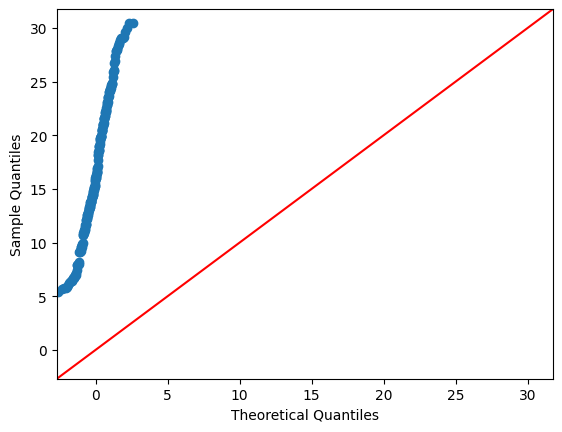

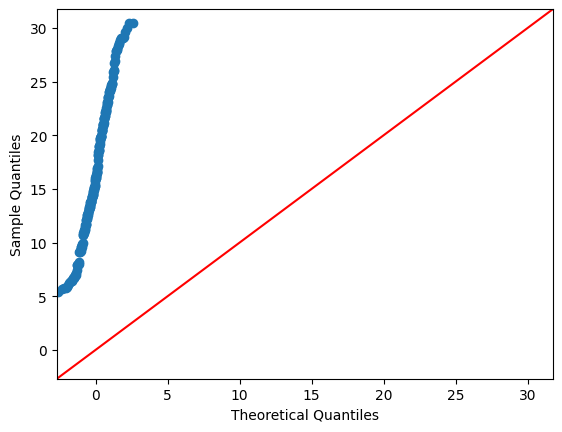

In [54]:
sm.qqplot(np.array(annualized_returns), line ='45')

((array([3.46573590e-03, 8.43263005e-03, 1.34784950e-02, 1.85499498e-02,
         2.36472554e-02, 2.87706768e-02, 3.39204828e-02, 3.90969467e-02,
         4.43003458e-02, 4.95309620e-02, 5.47890815e-02, 6.00749950e-02,
         6.53889979e-02, 7.07313904e-02, 7.61024774e-02, 8.15025688e-02,
         8.69319796e-02, 9.23910299e-02, 9.78800451e-02, 1.03399356e-01,
         1.08949299e-01, 1.14530215e-01, 1.20142454e-01, 1.25786367e-01,
         1.31462315e-01, 1.37170663e-01, 1.42911784e-01, 1.48686055e-01,
         1.54493863e-01, 1.60335598e-01, 1.66211659e-01, 1.72122454e-01,
         1.78068393e-01, 1.84049898e-01, 1.90067397e-01, 1.96121326e-01,
         2.02212127e-01, 2.08340255e-01, 2.14506168e-01, 2.20710335e-01,
         2.26953235e-01, 2.33235353e-01, 2.39557186e-01, 2.45919238e-01,
         2.52322026e-01, 2.58766074e-01, 2.65251917e-01, 2.71780101e-01,
         2.78351183e-01, 2.84965729e-01, 2.91624319e-01, 2.98327543e-01,
         3.05076004e-01, 3.11870316e-01, 3.18711107

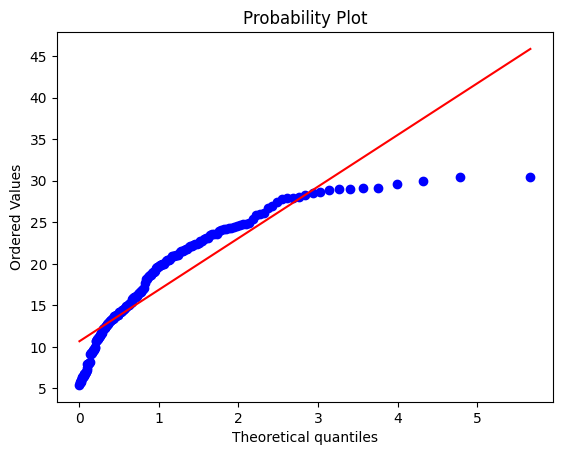

In [56]:
import scipy
scipy.stats.probplot(annualized_returns, dist="expon", plot=plt)